In [1]:
import shap
import pickle
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings

In [3]:
model_name = 'final.pkl'

with open(f'../output/fitted_models/{model_name}', 'rb') as fr:
    model = pickle.load(fr)

In [4]:
np.random.seed(1303)

In [376]:
df = pd.read_csv('../input/calcifications.csv')

train = pd.read_csv('../input/train_no_ohe.csv')
test = pd.read_csv('../input/test_no_ohe.csv')

train_ns = pd.read_csv('../input/train_no_ohe_no_scale.csv')
test_ns = pd.read_csv('../input/test_no_ohe_no_scale.csv')

In [377]:
train_ns_raw = train_ns.copy()
test_ns_raw = test_ns.copy()

X_train_ns_raw, y_train_ns_raw = train_ns_raw.drop('symptoms', axis=1), train_ns_raw['symptoms']
X_test_ns_raw, y_test_ns_raw = test_ns_raw.drop('symptoms', axis=1), test_ns_raw['symptoms']

In [378]:
"""
calc_map = {0: "Type 1", 
            1: "Type 2", 
            2: "Type 3", 
            3: "Type 4", 
            4: "Type 5", 
            5: "Type 6"}
"""
calc_map = {0: "No Calcification\n(Type 1)", 
            1: "Intimal or Superficial\n(Type 2)", 
            2: "Deep or Bulky\n(Type 3)", 
            3: "Adventitial\n(Type 4)", 
            4: "Mixed Intimal and Bulky\n(Type 5)", 
            5: "Positive Rim Sign\n(Type 6)"}

# give meaningful names to feature values
for c in ['calcification_type_left', 'calcification_type_right']:
    train_ns[c] = train_ns[c].map(calc_map)
    test_ns[c] = test_ns[c].map(calc_map)    

In [379]:
train_ns['gender'] = train_ns['gender'].map({0: 'Female', 1: 'Male'})
test_ns['gender'] = test_ns['gender'].map({0: 'Female', 1: 'Male'})

In [380]:
for c in ['hypertension', 'hyperlipidemia', 'TIA', 'cad', 'diabetes', 'smoker_status', 'symptoms']:
    train_ns[c] = train_ns[c].map({0: 'No', 1: 'Yes'})
    test_ns[c] = test_ns[c].map({0: 'No', 1: 'Yes'})    

In [381]:
# set types of binary/categorical variables to category
train_ns = train_ns.astype({
    "calcification_type_left": 'category',
    "calcification_type_right": 'category',
    "TIA": 'category',
    "hypertension": 'category',
    "cad": 'category',
    "smoker_status": 'category',
    "gender": 'category',
    "diabetes": 'category',
    "hyperlipidemia": 'category'
})
test_ns = test_ns.astype({
    "calcification_type_left": 'category',
    "calcification_type_right": 'category',
    "TIA": 'category',
    "hypertension": 'category',
    "cad": 'category',
    "smoker_status": 'category',
    "gender": 'category',
    "diabetes": 'category',
    "hyperlipidemia": 'category'
})

In [382]:
X_train, y_train = train.drop('symptoms', axis=1), train['symptoms']
X_test, y_test = test.drop('symptoms', axis=1), test['symptoms']

X_train_ns, y_train_ns = train_ns.drop('symptoms', axis=1), train_ns['symptoms']
X_test_ns, y_test_ns = test_ns.drop('symptoms', axis=1), test_ns['symptoms']

In [383]:
X_test_ns['calcification_type_right'] = X_test_ns['calcification_type_right'].astype(
pd.api.types.CategoricalDtype(categories=['No Calcification\n(Type 1)',
                                         'Intimal or Superficial\n(Type 2)',
                                         'Deep or Bulky\n(Type 3)',
                                         'Adventitial\n(Type 4)',
                                         'Mixed Intimal and Bulky\n(Type 5)',
                                         'Positive Rim Sign\n(Type 6)'],
                             ordered=True)
)
X_test_ns['calcification_type_left'] = X_test_ns['calcification_type_left'].astype(
pd.api.types.CategoricalDtype(categories=['No Calcification\n(Type 1)',
                                         'Intimal or Superficial\n(Type 2)',
                                         'Deep or Bulky\n(Type 3)',
                                         'Adventitial\n(Type 4)',
                                         'Mixed Intimal and Bulky\n(Type 5)',
                                         'Positive Rim Sign\n(Type 6)'],
                             ordered=True)
)

In [384]:
all_ns = pd.concat([train_ns, test_ns], axis=0)
X_ns = all_ns.drop('symptoms', axis=1)
y_ns = all_ns.symptoms

In [385]:
columns_map = {
    "calcification_type_left": "Calcification Type (Left)",
    "calcification_type_right": "Calcification Type (Right)",
    "TIA": "TIA",
    "hypertension": "Hypertension",
    "cad": "CAD",
    "smoker_status": "Is Smoker",
    "age": "Age (Years)",
    "gender": "Gender",
    "diabetes": "Diabetes",
    "hyperlipidemia": "Hyperlipidemia",
    "stenosis_right": "Stenosis (Right)",
    "stenosis_left": "Stenosis (Left)",
    "symptoms": "Cerebrovascular Events"
}

In [386]:
X_test_ns = X_test_ns.rename(columns=columns_map)
X_train_ns = X_test_ns.rename(columns=columns_map)
X_test_ns_raw = X_test_ns_raw.rename(columns=columns_map)
all_ns = X_test_ns.rename(columns=columns_map)

In [387]:
# custom cmap
from matplotlib.cm import register_cmap, get_cmap
import matplotlib.colors as clr
custom_cmap = clr.LinearSegmentedColormap.from_list('custom cmap', ['#b0c4de','#ff8c69'], N=256)
#register_cmap("bluesalmon", custom_cmap)

# Start SHAPing

In [17]:
explainer = shap.Explainer(model)
#shaps = explainer(X_test)

expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]

In [18]:
exp = shap.Explainer(model, X_test_ns_raw)
sh = exp(X_test_ns_raw)
sh.display_data = X_test_ns.values

In [19]:
def get_interaction_values(explainer, X):
    shaps = explainer(X)
    shap_interaction_values = explainer.shap_interaction_values(X)
    if isinstance(shap_interaction_values, list):
        shap_interaction_values = shap_interaction_values[1]
        
    return shap_interaction_values

# Summary plots: Beeswarm + bar

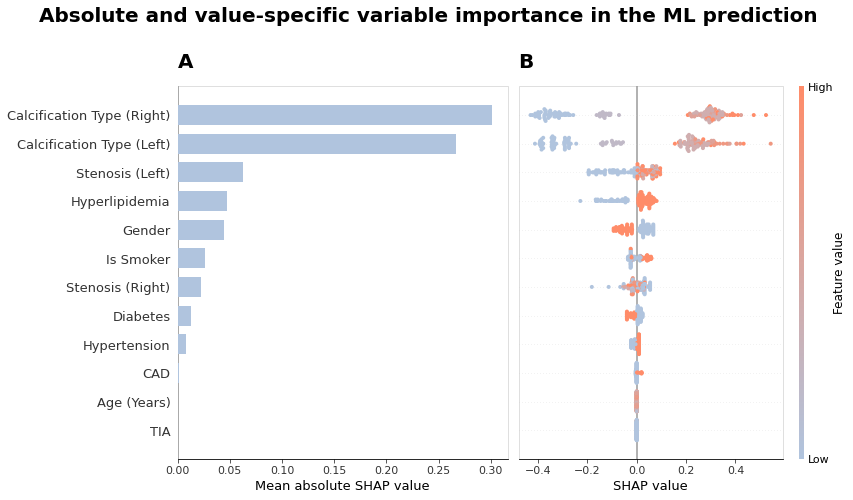

In [815]:
np.random.seed(1303)
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
shap.summary_plot(sh, 
                  plot_type='bar', 
                  show=False, 
                  color="lightsteelblue",
                  plot_size=None)
ax1.set_xlabel("Mean absolute SHAP value")
ax1.patch.set_edgecolor('lightgray')  
ax1.patch.set_linewidth('0.7')  


ax2 = fig.add_subplot(122)

shap.summary_plot(sh, show=False, plot_size=None, cmap=custom_cmap)
ax2.set_xlabel("SHAP value")
#plt.gca().get_yaxis().set_ticks([])
ax2.set_yticks([])
ax2.patch.set_edgecolor('lightgray')  
ax2.patch.set_linewidth('0.7')

plt.tight_layout()


ax1.text(0, 1.05, "A", transform=ax1.transAxes, size=20, weight='bold')
ax2.text(0, 1.05, "B", transform=ax2.transAxes, size=20, weight='bold')

#print(matplotlib.rcParams['font.family'])
plt.suptitle("Absolute and value-specific variable importance in the ML prediction", x=0.5, y=1.15, fontsize=20, weight="bold")


plt.savefig("../output/plots/bee_and_bars_v2.pdf", dpi=400, bbox_inches='tight')
plt.show()

# Dependence plots
Calcification Type Left/Right with stenosis as interaction

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


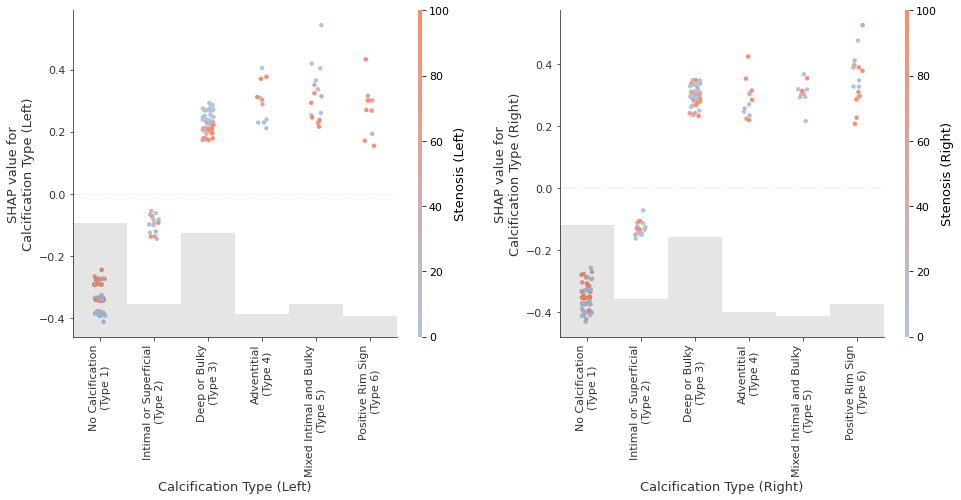

In [225]:
np.random.seed(1303)
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
shap.plots.scatter(sh[:, "Calcification Type (Left)"],
                  color=sh[:, "Stenosis (Left)"],
                  ax=ax[0], show=False,
                  cmap=custom_cmap,
                  dot_size=20,
                  x_jitter=0.2)
shap.plots.scatter(sh[:, "Calcification Type (Right)"],
                  color=sh[:, "Stenosis (Right)"],
                  ax=ax[1], show=False,
                  cmap=custom_cmap,
                  dot_size=20,
                  x_jitter=0.2)
#labels = ax.get_xticklabels()
#labels = [''] + list(calc_map.values()) + ['']
#ax.set_xticklabels(labels)
#plt.xticks(rotation=90)
plt.savefig("../output/plots/dependency_calcifLR_stenosis.pdf", dpi=400, bbox_inches='tight')
plt.show()

# Accumulated Local Effects

In [785]:
from PyALE import ale
import matplotlib

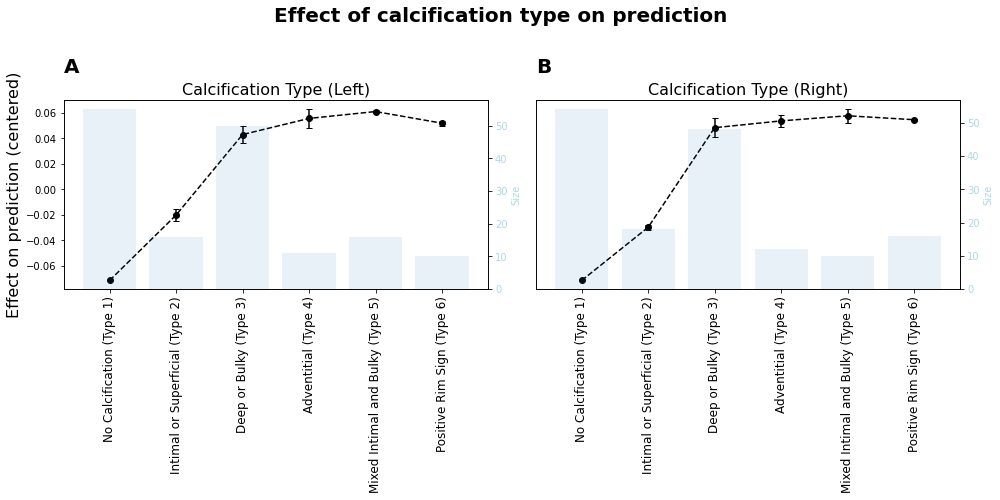

In [803]:
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
ale_left = ale(X=X_test_ns_raw, model=model, 
              feature=["Calcification Type (Left)"],
              feature_type='discrete',
              ax=axes[0],
              fig=f
             )
f.gca().set_title("Calcification Type (Left)", 
                  fontdict={'fontsize': 16})

ale_right = ale(X=X_test_ns_raw, model=model, 
              feature=["Calcification Type (Right)"],
              feature_type='discrete',
              ax=axes[1],
              fig=f
             )
f.gca().set_title("Calcification Type (Right)",
                 fontdict={'fontsize': 16})

# change xticks labels
for ax in axes:
    ax.set_xlabel("")
    ax.set_xticks(list(range(6)))
    ax.set_xticklabels([calc_map[v] for v in range(6)], 
                       minor=False, 
                       fontdict={'fontsize': 12},
                       rotation=90)

axes[0].yaxis.label.set_size(16)
axes[1].set_yticks([])
axes[1].set_ylabel("")

plt.tight_layout()

axes[0].text(0, 1.15, "A", transform=axes[0].transAxes, size=20, weight='bold')
axes[1].text(0, 1.15, "B", transform=axes[1].transAxes, size=20, weight='bold')

#print(matplotlib.rcParams['font.family'])
plt.suptitle("Effect of calcification type on prediction", y=1.15, fontsize=20, weight="bold")

plt.savefig("../output/plots/ale_calc.pdf", dpi=400, bbox_inches='tight')

# Decision plots

In [90]:
pos_class_proba = model.predict(X_test)
threshold = 0.5
fn_mask = (pos_class_proba < threshold) & (y_test_ns_raw == 1)
fp_mask = (pos_class_proba >= threshold) & (y_test_ns_raw == 0)
tp_mask = (pos_class_proba >= threshold) & (y_test_ns_raw == 1)
tn_mask = (pos_class_proba < threshold) & (y_test_ns_raw == 0)

Text(0.5, 1.0, 'True Negatives')

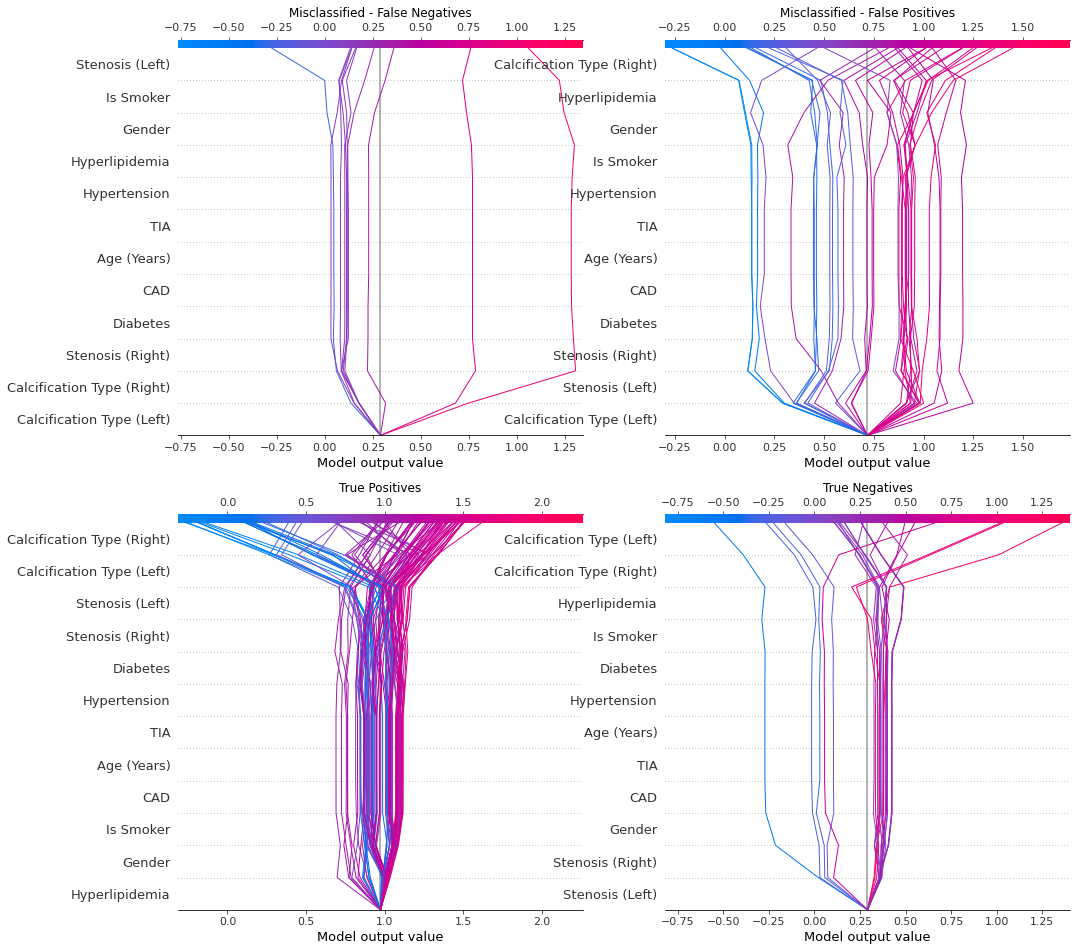

In [102]:
#y_pred = (sh.sum(1) + expected_value) > 0
#misclassified = y_pred != y_test_subset

fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(221)
exp_masked = shap.Explainer(model, X_test_ns_raw[fn_mask])
sh_masked = exp_masked(X_test_ns_raw[fn_mask])
sh_masked.display_data = X_test_ns[fn_mask].values
shap.decision_plot(exp_masked.expected_value, 
                   sh_masked.values, 
                   X_test_ns_raw[fn_mask],
                   feature_names=list(X_test_ns_raw.columns),
                   #highlight=len(sh_masked.values)-1,
                   feature_order="hclust", 
                   show=False, auto_size_plot=False) 
ax1.set_title("Misclassified - False Negatives")

ax2 = fig.add_subplot(222)
exp_masked = shap.Explainer(model, X_test_ns_raw[fp_mask])
sh_masked = exp_masked(X_test_ns_raw[fp_mask])
sh_masked.display_data = X_test_ns[fp_mask].values
shap.decision_plot(exp_masked.expected_value, sh_masked.values, X_test_ns_raw[fp_mask],
                   feature_names=list(X_test_ns_raw.columns),
                   feature_order="hclust", show=False, auto_size_plot=False) 
#ax2.set_yticks([])
ax2.set_title("Misclassified - False Positives")

ax3 = fig.add_subplot(223)
exp_masked = shap.Explainer(model, X_test_ns_raw[tp_mask])
sh_masked = exp_masked(X_test_ns_raw[tp_mask])
sh_masked.display_data = X_test_ns[tp_mask].values
shap.decision_plot(exp_masked.expected_value, sh_masked.values, X_test_ns_raw[tp_mask],
                   feature_names=list(X_test_ns_raw.columns),
                   feature_order="hclust", show=False, auto_size_plot=False) 
ax3.set_title("True Positives")

ax4 = fig.add_subplot(224)
exp_masked = shap.Explainer(model, X_test_ns_raw[tn_mask])
sh_masked = exp_masked(X_test_ns_raw[tn_mask])
sh_masked.display_data = X_test_ns[tn_mask].values
shap.decision_plot(exp_masked.expected_value, sh_masked.values, X_test_ns_raw[tn_mask],
                   feature_names=list(X_test_ns_raw.columns),
                   feature_order="hclust", show=False, auto_size_plot=False) 
ax4.set_title("True Negatives")
#ax4.set_yticks([])

Text(0.5, 1.0, 'All with false negatives highlighted')

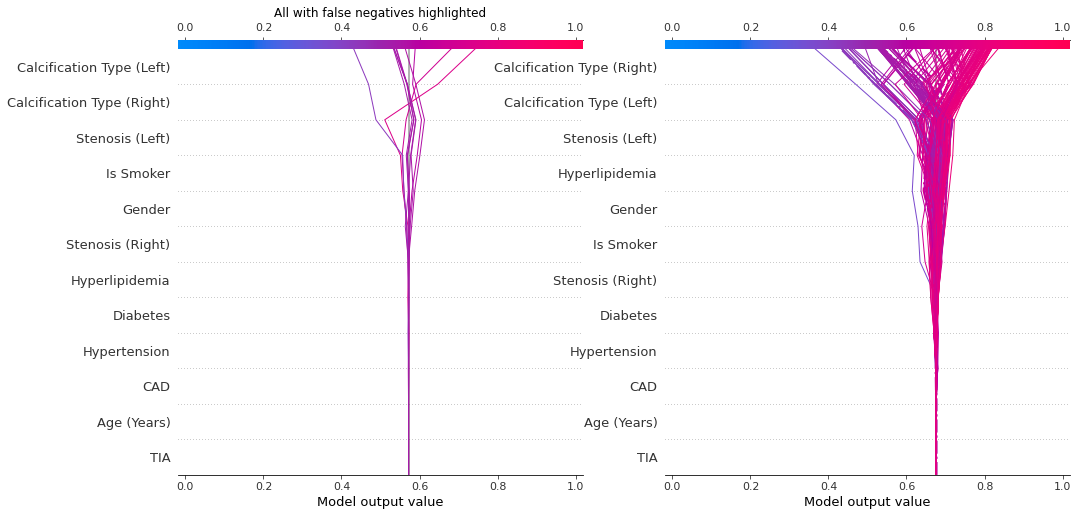

In [106]:
#y_pred = (sh.sum(1) + expected_value) > 0
#misclassified = y_pred != y_test_subset
fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(121)
exp_masked = shap.Explainer(model, X_test_ns_raw[fn_mask])
sh_masked = exp_masked(X_test_ns_raw[fn_mask])
sh_masked.display_data = X_test_ns[fn_mask].values
shap.decision_plot(exp_masked.expected_value, 
                   sh_masked.values, 
                   X_test_ns_raw[fn_mask],
                   feature_names=list(X_test_ns_raw.columns),
                   #highlight=len(sh_masked.values)-1,
                   #feature_order="hclust", 
                   link='logit',
                   show=False, auto_size_plot=False) 
ax1.set_title("Misclassified - False Negatives")

ax2 = fig.add_subplot(122)
exp_masked = shap.Explainer(model, X_test_ns_raw)
sh_masked = exp_masked(X_test_ns_raw)
sh_masked.display_data = X_test_ns.values
shap.decision_plot(exp_masked.expected_value, sh_masked.values, X_test_ns_raw,
                   feature_names=list(X_test_ns_raw.columns),
                   #feature_order="hclust", 
                   link="logit",
                   show=False, auto_size_plot=False,
                  highlight=fn_mask) 
ax1.set_title("All with false negatives highlighted")

## Focus on misclassifications

In [138]:
# index of false negatives
print("Indices of false negatives: ", list(fn_mask[fn_mask == True].index))
print("Indices of false positives: ", list(fn_mask[fp_mask == True].index))

Indices of false negatives:  [8, 61, 69, 87, 113, 120, 124, 128, 135, 141]
Indices of false positives:  [3, 4, 6, 7, 11, 15, 24, 31, 36, 42, 43, 44, 46, 48, 49, 56, 58, 66, 68, 71, 73, 84, 85, 96, 100, 111, 116, 117, 118, 119, 137, 147, 150]


In [145]:
# Visualize predicted probabilities of false negatives along with index
print("False negatives")
[f"{idx}: {proba}" for idx, proba in zip(fn_mask[fn_mask == True].index, pos_class_proba[fn_mask])]

False negatives


['8: 0.4650629241561142',
 '61: 0.4493321258277418',
 '69: 0.4958433498464295',
 '87: 0.4445401078317002',
 '113: 0.29366606138599927',
 '120: 0.48895830357161413',
 '124: 0.48305682349528695',
 '128: 0.41147828872488373',
 '135: 0.4698606161437534',
 '141: 0.4938228112043316']

In [146]:
# Visualize predicted probabilities of false negatives along with index
print("False positives")
[f"{idx}: {proba}" for idx, proba in zip(fp_mask[fp_mask == True].index, pos_class_proba[fp_mask])]

False positives


['3: 0.665470281665481',
 '4: 0.6280814391349894',
 '6: 0.5815031182794422',
 '7: 0.5015608456806018',
 '11: 0.5765894289547274',
 '15: 0.6351302294708762',
 '24: 0.7897705326563806',
 '31: 0.5005585009178705',
 '36: 0.5487687810944202',
 '42: 0.5667822014835342',
 '43: 0.5911602908462213',
 '44: 0.5073538916446964',
 '46: 0.5149267142800248',
 '48: 0.5180657509524957',
 '49: 0.8372780913281674',
 '56: 0.7269830452140135',
 '58: 0.7039283748975719',
 '66: 0.5675530652285297',
 '68: 0.5835369829990799',
 '71: 0.6058610354088704',
 '73: 0.788808924337759',
 '84: 0.566618825384862',
 '85: 0.7332898680273072',
 '96: 0.5833473322796956',
 '100: 0.5058123714795614',
 '111: 0.5669512181893179',
 '116: 0.5530191700241868',
 '117: 0.564948920552577',
 '118: 0.5046738662996051',
 '119: 0.7465892557186122',
 '137: 0.72307111984934',
 '147: 0.6064010881119872',
 '150: 0.5020395153271774']

In [135]:
# Visualize features of a false negative
print(X_test_ns_raw.iloc[113])
print("Symptoms: ", y_test_ns_raw[113])

Calcification Type (Right)     0.0
Calcification Type (Left)      0.0
TIA                            0.0
Hypertension                   1.0
CAD                            0.0
Is Smoker                      0.0
Age (Years)                   69.0
Gender                         1.0
Diabetes                       0.0
Hyperlipidemia                 0.0
Stenosis (Right)              20.0
Stenosis (Left)               10.0
Name: 113, dtype: float64
Symptoms:  1


In [147]:
# Visualize features of a false positive
print(X_test_ns_raw.iloc[49])
print("Symptoms: ", y_test_ns_raw[49])

Calcification Type (Right)     4.0
Calcification Type (Left)      5.0
TIA                            0.0
Hypertension                   1.0
CAD                            0.0
Is Smoker                      0.0
Age (Years)                   68.0
Gender                         1.0
Diabetes                       0.0
Hyperlipidemia                 1.0
Stenosis (Right)               0.0
Stenosis (Left)               80.0
Name: 49, dtype: float64
Symptoms:  0


In [150]:
[f"{idx}: {col}" for idx, col in enumerate(X_test_ns_raw.columns)]
# 1, 0, 11, 9, 7, 10, 5, 8, 4, 3, 6, 2

['0: Calcification Type (Right)',
 '1: Calcification Type (Left)',
 '2: TIA',
 '3: Hypertension',
 '4: CAD',
 '5: Is Smoker',
 '6: Age (Years)',
 '7: Gender',
 '8: Diabetes',
 '9: Hyperlipidemia',
 '10: Stenosis (Right)',
 '11: Stenosis (Left)']

## A false negative and a false positiver
We focus on the two errors where the model was most certain (highest probability)

Text(-0.12, 1.0, 'B1')

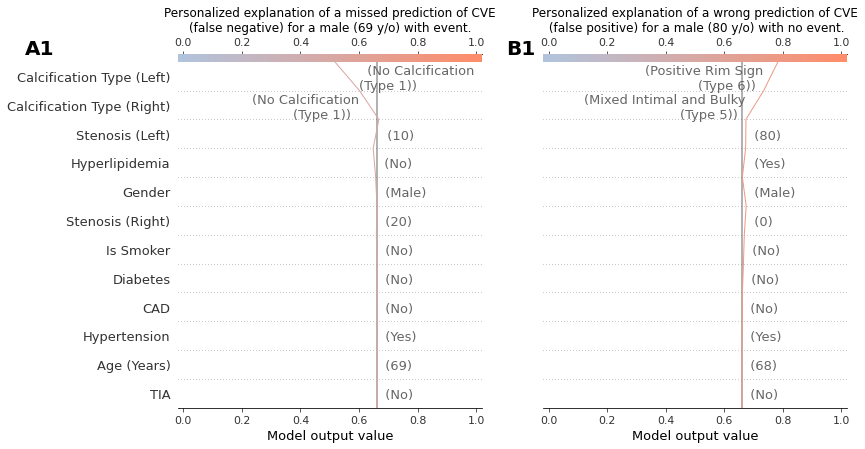

In [832]:
import string

# Introspection of a false negative and false positive for whom the model was confident:
# low probability for false negative and high probability for false positive
fig = plt.figure(figsize=(12,6.5))


feature_order = list(reversed([1, 0, 11, 9, 7, 10, 5, 8, 4, 3, 6, 2]))

ax1 = fig.add_subplot(121)
shap.decision_plot(expected_value, 
                   sh.values[113], 
                   X_test_ns.iloc[113],
                   feature_names=list(X_test_ns_raw.columns),
                   #highlight=8,
                   #feature_order="hclust", 
                   link='logit',
                   feature_order=feature_order,
                   plot_color=custom_cmap,
                   show=False, auto_size_plot=False) 
ax1.set_title("Personalized explanation of a missed prediction of CVE\n(false negative) for a male (69 y/o) with event.")

ax2 = fig.add_subplot(122) 
shap.decision_plot(expected_value, 
                   sh.values[49], 
                   X_test_ns.iloc[49],
                   feature_names=list(X_test_ns_raw.columns),
                   #highlight=8,
                   #feature_order="hclust", 
                   link='logit',
                   feature_order=feature_order,
                   plot_color=custom_cmap,
                   show=False, auto_size_plot=False) 
ax2.set_title("Personalized explanation of a wrong prediction of CVE\n (false positive) for a male (80 y/o) with no event.")
ax2.set_yticks([])


ax1.text(-0.5, 1.0, "A1", transform=ax1.transAxes, 
        size=20, weight='bold')
ax2.text(-0.12, 1.0, "B1", transform=ax2.transAxes, 
        size=20, weight='bold')

### Waterfall plots

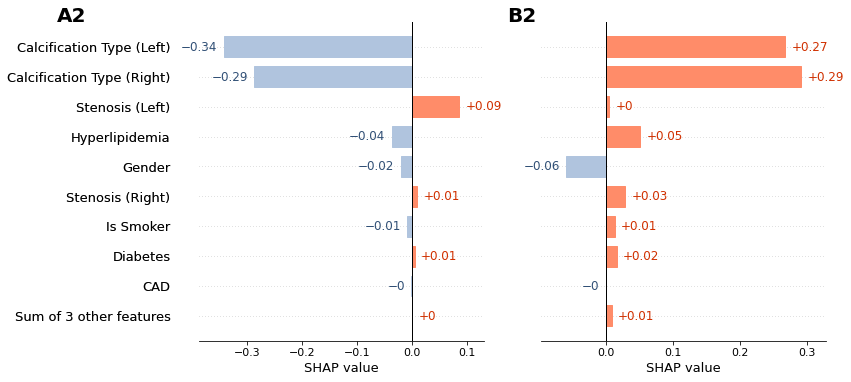

In [833]:
import matplotlib
matplotlib.rc('image', cmap='Dark2')

waterfall_fig = plt.figure(figsize=(1,6.5))

waterfall_ax1 = waterfall_fig.add_subplot(121)
shap.plots.bar(sh[113], show=False, 
               order=list(reversed(feature_order))
              )
waterfall_ax1.tick_params(axis='y', which='major', pad=25)
#ax1.set_cmap('Dark2')

waterfall_ax2 = waterfall_fig.add_subplot(122) 
shap.plots.bar(sh[49], show=False, order=list(reversed(feature_order)))
waterfall_ax2.set_yticks([])

plt.tight_layout(rect=[0.3, 0.2, 1.8, 1])

fst_annotations = [child for child in waterfall_ax1.get_children() if isinstance(child, matplotlib.text.Text)]   
snd_annotations = [child for child in waterfall_ax2.get_children() if isinstance(child, matplotlib.text.Text)]

#'#b0c4de','#ff8c69'

fst_to_lightblue = [0, 1, 3, 4, 6, 8]
fst_to_salmon = [2, 5, 7, 9]

snd_to_lightblue = [4, 8]
snd_to_salmon = [0,1,2,3,5,6,7,9]

# first plot
for idx in fst_to_lightblue:
    waterfall_ax1.patches[idx].set_color("#b0c4de")
    fst_annotations[idx].set_color("#315076")
    
for idx in fst_to_salmon:
    waterfall_ax1.patches[idx].set_color("#ff8c69")  
    fst_annotations[idx].set_color("#d03000")
    
# second plot
for idx in snd_to_lightblue:
    waterfall_ax2.patches[idx].set_color("#b0c4de")
    snd_annotations[idx].set_color("#315076")    
    
for idx in snd_to_salmon:
    waterfall_ax2.patches[idx].set_color("#ff8c69") 
    snd_annotations[idx].set_color("#d03000")    
    
    
waterfall_ax1.text(-0.5, 1.0, "A2", transform=waterfall_ax1.transAxes, 
        size=20, weight='bold')
waterfall_ax2.text(-0.12, 1.0, "B2", transform=waterfall_ax2.transAxes, 
        size=20, weight='bold')

plt.show()

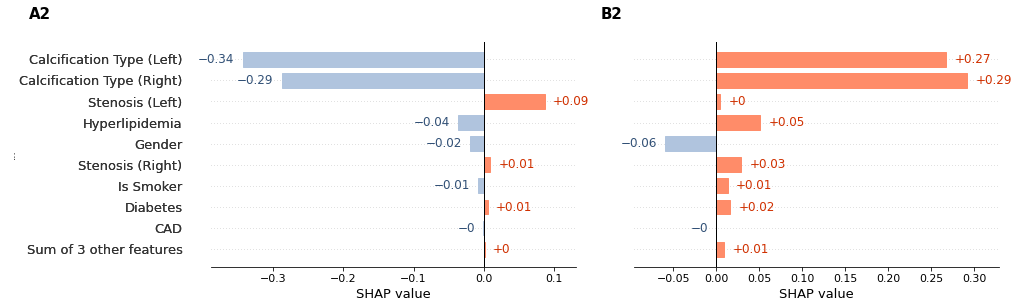

In [456]:
import matplotlib
    
def make_waterfalls():
    waterfall_fig = plt.figure(figsize=(1,6.5))

    waterfall_ax1 = waterfall_fig.add_subplot(121)
    shap.plots.bar(sh[113], show=False, 
                   order=list(reversed(feature_order))
                  )
    waterfall_ax1.tick_params(axis='y', which='major', pad=25)
    plt.ylabel("...", labelpad=2)
    #ax1.set_cmap('Dark2')

    waterfall_ax2 = waterfall_fig.add_subplot(122) 
    shap.plots.bar(sh[49], show=False, order=list(reversed(feature_order)))
    waterfall_ax2.set_yticks([])

    plt.tight_layout(rect=[0, 0.2, 1.8, 0.8]) 
    # first: 
    # second: 
    # third: 
    # fourth: height of bars

    fst_annotations = [child for child in waterfall_ax1.get_children() if isinstance(child, matplotlib.text.Text)]   
    snd_annotations = [child for child in waterfall_ax2.get_children() if isinstance(child, matplotlib.text.Text)]

    #'#b0c4de','#ff8c69'

    fst_to_lightblue = [0, 1, 3, 4, 6, 8]
    fst_to_salmon = [2, 5, 7, 9]

    snd_to_lightblue = [4, 8]
    snd_to_salmon = [0,1,2,3,5,6,7,9]

    # first plot
    for idx in fst_to_lightblue:
        waterfall_ax1.patches[idx].set_color("#b0c4de")
        fst_annotations[idx].set_color("#315076")

    for idx in fst_to_salmon:
        waterfall_ax1.patches[idx].set_color("#ff8c69")  
        fst_annotations[idx].set_color("#d03000")

    # second plot
    for idx in snd_to_lightblue:
        waterfall_ax2.patches[idx].set_color("#b0c4de")
        snd_annotations[idx].set_color("#315076")    

    for idx in snd_to_salmon:
        waterfall_ax2.patches[idx].set_color("#ff8c69") 
        snd_annotations[idx].set_color("#d03000")    
        
    #waterfall_ax1.tick_params(axis='y', color='gray')
    [t.set_color('#333333') for t in waterfall_ax1.yaxis.get_ticklabels()]
    
    #plt.show()
    waterfall_ax1.text(-0.5, 1.1, "A2", transform=waterfall_ax1.transAxes, 
        size=15, weight='bold')
    waterfall_ax2.text(-0.09, 1.1, "B2", transform=waterfall_ax2.transAxes, 
        size=15, weight='bold')

make_waterfalls()

Plot decision plots and waterfall plots in a 2x2 grid

<class 'matplotlib.axes._subplots.AxesSubplot'>


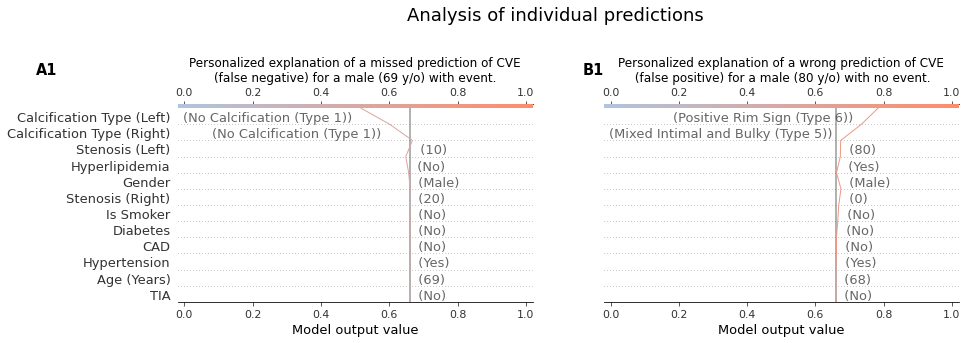

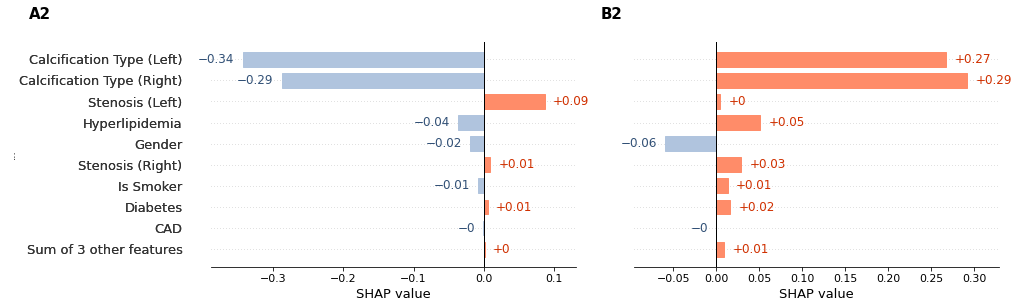

In [470]:
import string
from copy import copy

Xtc = X_test_ns.copy()
calc_map = {0: "No Calcification (Type 1)", 
            1: "Intimal or Superficial (Type 2)", 
            2: "Deep or Bulky (Type 3)", 
            3: "Adventitial (Type 4)", 
            4: "Mixed Intimal and Bulky (Type 5)", 
            5: "Positive Rim Sign (Type 6)"}

# give meaningful names to feature values
for c in ['Calcification Type (Left)', 'Calcification Type (Right)']:
    Xtc[c] = X_test_ns_raw[c].map(calc_map)    
    
Xtc['Calcification Type (Right)'] = Xtc['Calcification Type (Right)'].astype(
pd.api.types.CategoricalDtype(categories=['No Calcification (Type 1)',
                                         'Intimal or Superficial (Type 2)',
                                         'Deep or Bulky (Type 3)',
                                         'Adventitial (Type 4)',
                                         'Mixed Intimal and Bulky (Type 5)',
                                         'Positive Rim Sign (Type 6)'],
                             ordered=True)
)
Xtc['Calcification Type (Left)'] = Xtc['Calcification Type (Left)'].astype(
pd.api.types.CategoricalDtype(categories=['No Calcification (Type 1)',
                                         'Intimal or Superficial (Type 2)',
                                         'Deep or Bulky (Type 3)',
                                         'Adventitial (Type 4)',
                                         'Mixed Intimal and Bulky (Type 5)',
                                         'Positive Rim Sign (Type 6)'],
                             ordered=True)
)

exp = shap.Explainer(model, X_test_ns_raw)
sh = exp(X_test_ns_raw)
sh.display_data = Xtc.values

# Introspection of a false negative and false positive for whom the model was confident:
# low probability for false negative and high probability for false positive
fig = plt.figure(figsize=(14,8))
#plt.text(x=0.5, y=0.0, s="ciao", fontsize=18, ha="center", transform=fig.transFigure)

feature_order = list(reversed([1, 0, 11, 9, 7, 10, 5, 8, 4, 3, 6, 2]))

ax1 = fig.add_subplot(221)
shap.decision_plot(expected_value, 
                   sh.values[113], 
                   Xtc.iloc[113],
                   feature_names=list(X_test_ns_raw.columns),
                   #highlight=8,
                   #feature_order="hclust", 
                   link='logit',
                   feature_order=feature_order,
                   plot_color=custom_cmap,
                   show=False, auto_size_plot=False) 
ax1.set_title("Personalized explanation of a missed prediction of CVE\n(false negative) for a male (69 y/o) with event.")

ax2 = fig.add_subplot(222) 
shap.decision_plot(expected_value, 
                   sh.values[49], 
                   Xtc.iloc[49],
                   feature_names=list(X_test_ns_raw.columns),
                   #highlight=8,
                   #feature_order="hclust", 
                   link='logit',
                   feature_order=feature_order,
                   plot_color=custom_cmap,
                   show=False, auto_size_plot=False) 
ax2.set_title("Personalized explanation of a wrong prediction of CVE\n (false positive) for a male (80 y/o) with no event.")
ax2.set_yticks([])


ax1.text(-0.4, 1.15, "A1", transform=ax1.transAxes, 
        size=14.5, weight='bold')
ax2.text(-0.06, 1.15, "B1", transform=ax2.transAxes, 
        size=14.5, weight='bold')

fig.suptitle("Analysis of individual predictions", fontsize=18, y=1.05)

# add waterfall plots
make_waterfalls()

### Fancier plotting

(<Figure size 576x468 with 2 Axes>,
 <AxesSubplot:xlabel='Model output value'>,
 <AxesSubplot:xlabel='SHAP value', ylabel='...'>)

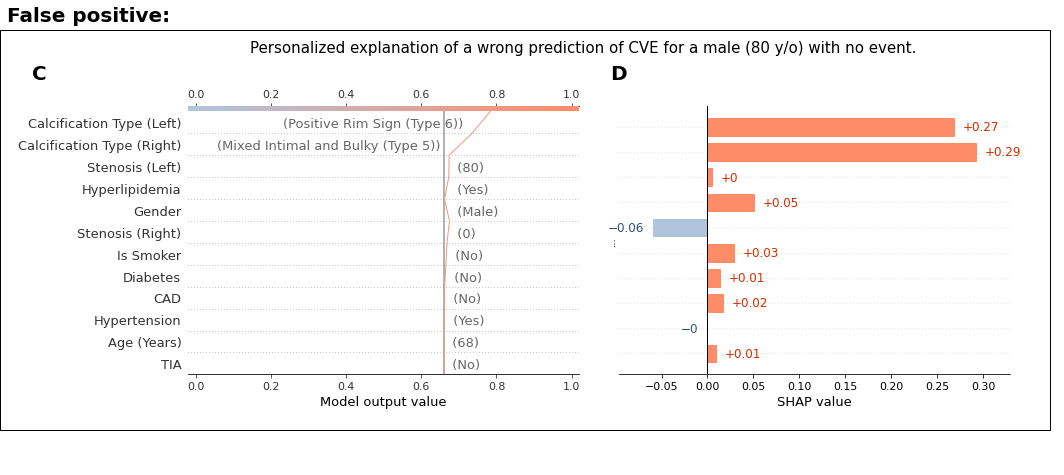

In [577]:
def plot_false_positive():
    fig = plt.figure(figsize=(14,8))
    
    fig.text(0, 1.05, "False positive:", size=20, weight='bold')    
        

    feature_order = list(reversed([1, 0, 11, 9, 7, 10, 5, 8, 4, 3, 6, 2]))

    ax1 = fig.add_subplot(121)
    shap.decision_plot(expected_value, 
                       sh.values[49], 
                       Xtc.iloc[49],
                       feature_names=list(X_test_ns_raw.columns),
                       #highlight=8,
                       #feature_order="hclust", 
                       link='logit',
                       feature_order=feature_order,
                       plot_color=custom_cmap,
                       show=False, auto_size_plot=False) 
    ax1.text(-0.4, 1.1, "C", transform=ax1.transAxes, 
        size=20, weight='bold')
    

    # add waterfall
    ax2 = fig.add_subplot(122)
    shap.plots.bar(sh[49], show=False, 
                   order=list(reversed(feature_order))
                  )
    ax2.tick_params(axis='y', which='major', pad=25)
    plt.ylabel("...", labelpad=2)
    ax2.set_yticks([])
    ax2.text(1.08, 1.1, "D", transform=ax1.transAxes, 
        size=20, weight='bold')
    
    # arrange subplots
    plt.tight_layout(rect=[0, 0.2, 1.8, 1.0]) 
    
    # add title to figure of two subplots
    fig.suptitle("Personalized explanation of a wrong prediction of CVE for a male (80 y/o) with no event.",
                x=1.0, y=1.01, fontsize=15)
    
    fst_annotations = [child for child in ax2.get_children() if isinstance(child, matplotlib.text.Text)]   
    #snd_annotations = [child for child in ax2.get_children() if isinstance(child, matplotlib.text.Text)]

    #'#b0c4de','#ff8c69'

    snd_to_lightblue = [4, 8]
    snd_to_salmon = [0,1,2,3,5,6,7,9]

    # first plot
    for idx in snd_to_lightblue:
        ax2.patches[idx].set_color("#b0c4de")
        fst_annotations[idx].set_color("#315076")

    for idx in snd_to_salmon:
        ax2.patches[idx].set_color("#ff8c69")  
        fst_annotations[idx].set_color("#d03000")   
        
    # add rectangle
    rect = plt.Rectangle((0, 45), 1050, 400, linewidth=1, edgecolor='black', facecolor='none')
    fig.patches.extend([rect])
    
    #plt.close()
    return fig, ax1, ax2

plot_false_positive()

(<Figure size 576x468 with 2 Axes>,
 <AxesSubplot:xlabel='Model output value'>,
 <AxesSubplot:xlabel='SHAP value', ylabel='...'>)

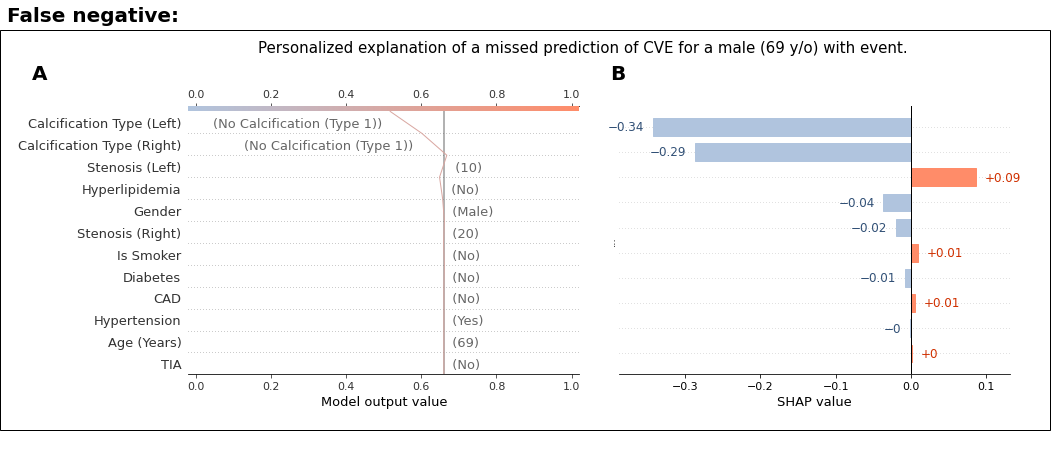

In [834]:
def plot_false_negative():
    fig = plt.figure(figsize=(14,8))
    
    fig.text(0, 1.05, "False negative:", size=20, weight='bold')    
        

    feature_order = list(reversed([1, 0, 11, 9, 7, 10, 5, 8, 4, 3, 6, 2]))

    ax1 = fig.add_subplot(121)
    shap.decision_plot(expected_value, 
                       sh.values[113], 
                       Xtc.iloc[113],
                       feature_names=list(X_test_ns_raw.columns),
                       #highlight=8,
                       #feature_order="hclust", 
                       link='logit',
                       feature_order=feature_order,
                       plot_color=custom_cmap,
                       show=False, auto_size_plot=False) 
    ax1.text(-0.4, 1.1, "A", transform=ax1.transAxes, 
        size=20, weight='bold')
    

    # add waterfall
    ax2 = fig.add_subplot(122)
    shap.plots.bar(sh[113], show=False, 
                   order=list(reversed(feature_order))
                  )
    ax2.tick_params(axis='y', which='major', pad=25)
    plt.ylabel("...", labelpad=2)
    ax2.set_yticks([])
    ax2.text(1.08, 1.1, "B", transform=ax1.transAxes, 
        size=20, weight='bold')
    
    # arrange subplots
    plt.tight_layout(rect=[0, 0.2, 1.8, 1.0]) 
    
    # add title to figure of two subplots
    fig.suptitle("Personalized explanation of a missed prediction of CVE for a male (69 y/o) with event.",
                x=1.0, y=1.01, fontsize=15)
    
    fst_annotations = [child for child in ax2.get_children() if isinstance(child, matplotlib.text.Text)]   
    #snd_annotations = [child for child in ax2.get_children() if isinstance(child, matplotlib.text.Text)]

    #'#b0c4de','#ff8c69'

    fst_to_lightblue = [0, 1, 3, 4, 6, 8]
    fst_to_salmon = [2, 5, 7, 9]

    # first plot
    for idx in fst_to_lightblue:
        ax2.patches[idx].set_color("#b0c4de")
        fst_annotations[idx].set_color("#315076")

    for idx in fst_to_salmon:
        ax2.patches[idx].set_color("#ff8c69")  
        fst_annotations[idx].set_color("#d03000")   
        
    # add rectangle
    rect = plt.Rectangle((0, 45), 1050, 400, linewidth=1, edgecolor='black', facecolor='none')
    fig.patches.extend([rect])
    
    #plt.close()
    return fig, ax1, ax2
plot_false_negative()

### Final plot: false negative and false positive on the same plot

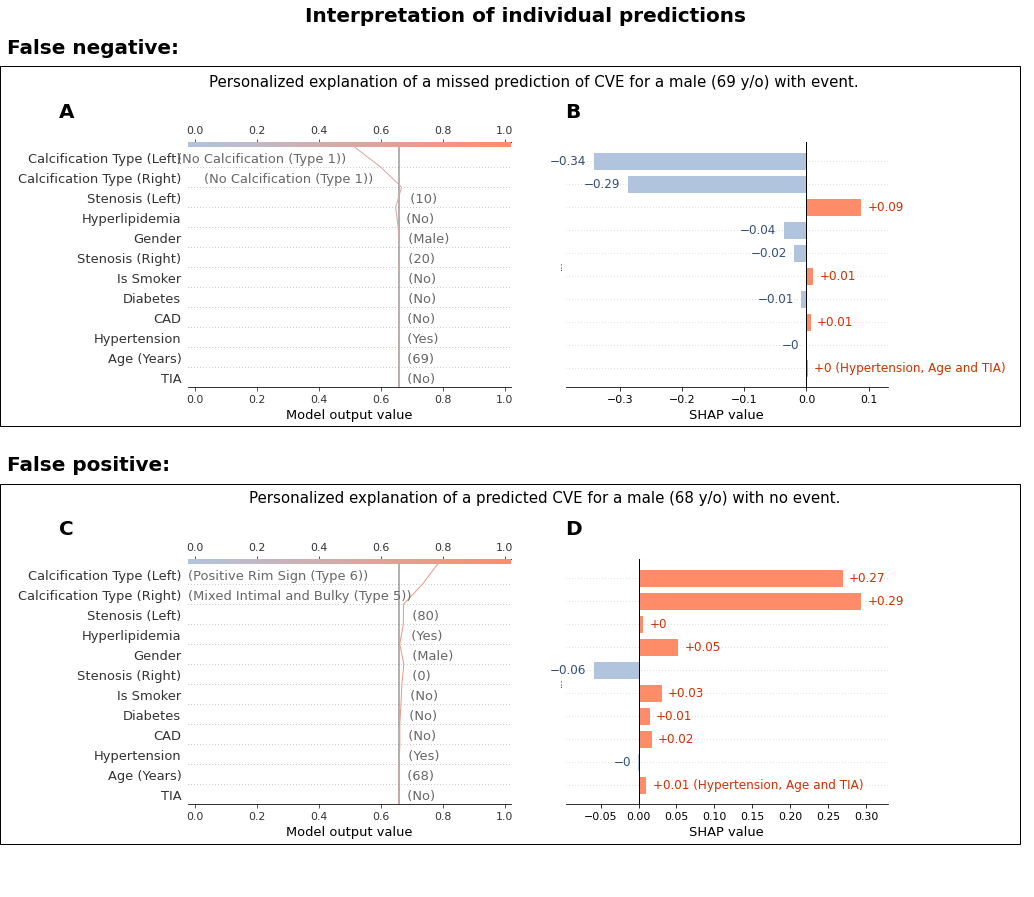

In [828]:
feature_order = list(reversed([1, 0, 11, 9, 7, 10, 5, 8, 4, 3, 6, 2]))


fig = plt.figure(figsize=(14,100))

### First figure start ###
fig.text(0, 1.9, "False negative:", size=20, weight='bold')    
fig.text(s="Personalized explanation of a missed prediction of CVE for a male (69 y/o) with event.",
            x=0.35, y=1.83, fontsize=15)

fst_ax1 = fig.add_subplot(221)
shap.decision_plot(expected_value, 
                   sh.values[113], 
                   Xtc.iloc[113],
                   feature_names=list(X_test_ns_raw.columns),
                   #highlight=8,
                   #feature_order="hclust", 
                   link='logit',
                   feature_order=feature_order,
                   plot_color=custom_cmap,
                   show=False, auto_size_plot=False) 
fst_ax1.text(-0.4, 1.1, "A", transform=fst_ax1.transAxes, 
    size=20, weight='bold')


# add waterfall
fst_ax2 = fig.add_subplot(222)
shap.plots.bar(sh[113], show=False, 
               order=list(reversed(feature_order))
              )
fst_ax2.tick_params(axis='y', which='major', pad=25)
plt.ylabel("...", labelpad=2)
fst_ax2.set_yticks([])
#ax2.text(1.08, 1.1, "B", transform=ax1.transAxes, size=20, weight='bold')
fst_ax2.text(0, 1.1, "B", transform=fst_ax2.transAxes, size=20, weight='bold')

fst_annotations = [child for child in fst_ax2.get_children() if isinstance(child, matplotlib.text.Text)]  
fst_annotations[-5].set_text(fst_annotations[-5].get_text() + " (Hypertension, Age and TIA)")

fst_to_lightblue = [0, 1, 3, 4, 6, 8]
fst_to_salmon = [2, 5, 7, 9]

# first plot
for idx in fst_to_lightblue:
    fst_ax2.patches[idx].set_color("#b0c4de")
    fst_annotations[idx].set_color("#315076")

for idx in fst_to_salmon:
    fst_ax2.patches[idx].set_color("#ff8c69")  
    fst_annotations[idx].set_color("#d03000")   

# add rectangle
rect = plt.Rectangle((0, 471), 1020, 360, linewidth=1, edgecolor='black', facecolor='none')
fig.patches.extend([rect])

### First figure end ###

# -------------------------------------------------------------

### Second figure start ###
fig.text(0, 1.01, "False positive:", size=20, weight='bold')  
fig.text(s="Personalized explanation of a predicted CVE for a male (68 y/o) with no event.",
            x=0.42, y=0.94, fontsize=15)

snd_ax1 = fig.add_subplot(223)
shap.decision_plot(expected_value, 
                   sh.values[49], 
                   Xtc.iloc[49],
                   feature_names=list(X_test_ns_raw.columns),
                   link='logit',
                   feature_order=feature_order,
                   plot_color=custom_cmap,
                   show=False, auto_size_plot=False) 
snd_ax1.text(-0.4, 1.1, "C", transform=snd_ax1.transAxes, 
    size=20, weight='bold')


# add waterfall
snd_ax2 = fig.add_subplot(224)
shap.plots.bar(sh[49], show=False, 
               order=list(reversed(feature_order))
              )
snd_ax2.tick_params(axis='y', which='major', pad=25)
plt.ylabel("...", labelpad=2)
snd_ax2.set_yticks([])
snd_ax2.text(0, 1.1, "D", transform=snd_ax2.transAxes, size=20, weight='bold')

snd_annotations = [child for child in snd_ax2.get_children() if isinstance(child, matplotlib.text.Text)] 
snd_annotations[-5].set_text(snd_annotations[-5].get_text() + " (Hypertension, Age and TIA)")

snd_to_lightblue = [4, 8]
snd_to_salmon = [0,1,2,3,5,6,7,9]

# first plot
for idx in snd_to_lightblue:
    snd_ax2.patches[idx].set_color("#b0c4de")
    snd_annotations[idx].set_color("#315076")

for idx in snd_to_salmon:
    snd_ax2.patches[idx].set_color("#ff8c69")  
    snd_annotations[idx].set_color("#d03000")   

    
# arrange subplots
plt.tight_layout(rect=[0, 0.2, 1.8, 1.8])
plt.subplots_adjust(hspace=0.7)

# add second rectangle
rect = plt.Rectangle((0, 53), 1020, 360, linewidth=1, edgecolor='black', facecolor='none')
fig.patches.extend([rect])

### Second figure end ###


# add general title to the plot
fig.suptitle("Interpretation of individual predictions", x=0.9, y=2, fontsize=20, weight="bold")


plt.savefig("../output/plots/misclassifications_v2.pdf", dpi=400, bbox_inches='tight')
plt.show()